In [1]:
import datetime
datetime.datetime.now()

datetime.datetime(2024, 6, 27, 10, 12, 24, 503636)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Lambda, Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from glob import glob
import json

In [3]:
if not os.path.exists('/content/data/'):

  api_token = {"username": "prabeshsharma",
                  "key": "e8929420b0f14df13c668815eef404a0"}

  with open('/content/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

  os.system('kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset')
  os.makedirs('/content/data/', exist_ok=True)
  os.system('mv /content/face-mask-12k-images-dataset.zip /content/data/face-mask-12k-images-dataset.zip')
  os.system('unzip -q /content/data/face-mask-12k-images-dataset.zip -d /content/data/')
  os.remove('/content/data/face-mask-12k-images-dataset.zip')

In [4]:

train_Data_path = "/content/data/Face Mask Dataset/Train"
validation_data_path = "/content/data/Face Mask Dataset/Validation"

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Assuming IMAGE_SIZE is defined elsewhere in your code
IMAGE_SIZE = [224, 224]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 0s 0us/step


In [6]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [7]:
folders = glob(r"/content/data/Face Mask Dataset/Train/*")

In [8]:
# our layers we can add more if we want
x = Flatten()(vgg.output)

In [9]:
prediction = Dense(len(folders),activation = 'softmax')(x)

#create a model object
model = Model(inputs = vgg.input, outputs= prediction)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model.compile(
loss = 'categorical_crossentropy',
optimizer = 'adam',
metrics=['accuracy'])

In [12]:
training_datagen = ImageDataGenerator(rescale=1./255)
training_data = training_datagen.flow_from_directory(train_Data_path,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 10000 images belonging to 2 classes.


In [13]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_data = valid_datagen.flow_from_directory(validation_data_path,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 800 images belonging to 2 classes.


In [14]:
model_path = "/content/model/modelvgg.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
r = model.fit(training_data,
                        epochs=50,
                        verbose=1,
                        validation_data=test_data,
                        callbacks=callbacks_list)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9770
Epoch 1: val_accuracy improved from -inf to 0.99625, saving model to /content/model/modelvgg.h5
313/313 [==============================] - 57s 151ms/step - loss: 0.0631 - accuracy: 0.9770 - val_loss: 0.0127 - val_accuracy: 0.9962
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9969
Epoch 2: val_accuracy improved from 0.99625 to 0.99750, saving model to /content/model/modelvgg.h5
313/313 [==============================] - 47s 151ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0099 - val_accuracy: 0.9975
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9985
Epoch 3: val_accuracy did not improve from 0.99750
313/313 [==============================] - 47s 150ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0107 - val_accuracy: 0.9950
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9995
Epoch 4: val_accuracy did not improve from 0.99750
313/313 [==============================] - 45s 145ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0077 - val_accuracy: 0.9975
Epoch 5/50
313/313 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9997
Epoch 5: val_accuracy di

In [16]:
def plot_graphs(histoy, string):
    plt.plot(histoy.history[string])
    plt.plot(histoy.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

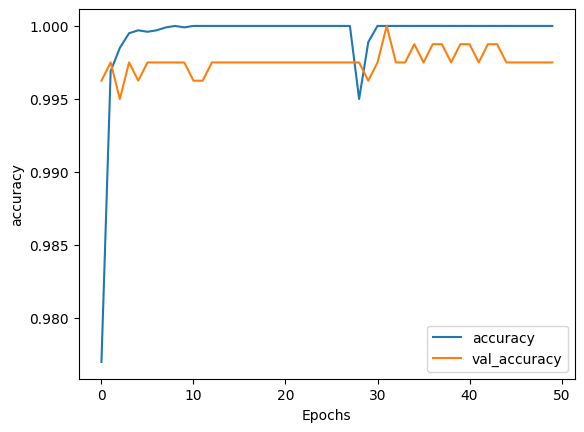

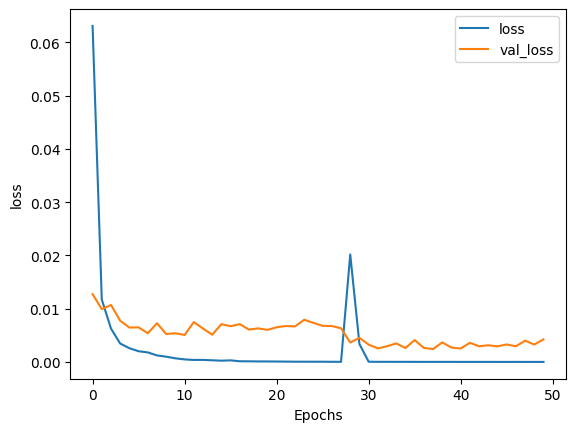

In [17]:
plot_graphs(r, 'accuracy')
plot_graphs(r, 'loss')

In [18]:
from tensorflow.keras.models import load_model
model.save("/content/model/modelvgg_last.h5")